In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/entity-annotated-corpus/ner.csv
/kaggle/input/entity-annotated-corpus/ner_dataset.csv


In [2]:
import pandas as pd
df = pd.read_csv("/kaggle/input/entity-annotated-corpus/ner.csv", encoding = "ISO-8859-1", error_bad_lines=False)
df.head()

b'Skipping line 281837: expected 25 fields, saw 34\n'


,Unnamed: 0,lemma,next-lemma,next-next-lemma,next-next-pos,next-next-shape,next-next-word,next-pos,next-shape,next-word,...,prev-prev-lemma,prev-prev-pos,prev-prev-shape,prev-prev-word,prev-shape,prev-word,sentence_idx,shape,word,tag
0,0,thousand,of,demonstr,NNS,lowercase,demonstrators,IN,lowercase,of,...,__start2__,__START2__,wildcard,__START2__,wildcard,__START1__,1.0,capitalized,Thousands,O
1,1,of,demonstr,have,VBP,lowercase,have,NNS,lowercase,demonstrators,...,__start1__,__START1__,wildcard,__START1__,capitalized,Thousands,1.0,lowercase,of,O
2,2,demonstr,have,march,VBN,lowercase,marched,VBP,lowercase,have,...,thousand,NNS,capitalized,Thousands,lowercase,of,1.0,lowercase,demonstrators,O
3,3,have,march,through,IN,lowercase,through,VBN,lowercase,marched,...,of,IN,lowercase,of,lowercase,demonstrators,1.0,lowercase,have,O
4,4,march,through,london,NNP,capitalized,London,IN,lowercase,through,...,demonstr,NNS,lowercase,demonstrators,lowercase,have,1.0,lowercase,marched,O


In [3]:
data = df[['sentence_idx','word','tag']]

data.head(20)

,sentence_idx,word,tag
0,1.0,Thousands,O
1,1.0,of,O
2,1.0,demonstrators,O
3,1.0,have,O
4,1.0,marched,O
5,1.0,through,O
6,1.0,London,B-geo
7,1.0,to,O
8,1.0,protest,O
9,1.0,the,O


In [4]:
df['tag'].value_counts()

O        889973
B-geo     37525
B-tim     20193
B-org     20184
I-per     17382
B-per     17011
I-org     16537
B-gpe     16392
I-geo      7409
I-tim      6298
B-art       434
B-eve       348
I-eve       297
I-art       280
I-gpe       229
B-nat       226
I-nat        76
Name: tag, dtype: int64

In [5]:
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["word"].values.tolist(),
                                                        s["tag"].values.tolist())]
        self.grouped = self.dataset.groupby("sentence_idx").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None
          
getter = SentenceGetter(data)
sentences = getter.sentences

In [6]:
print(sentences[1:3])

[[('Families', 'O'), ('of', 'O'), ('soldiers', 'O'), ('killed', 'O'), ('in', 'O'), ('the', 'O'), ('conflict', 'O'), ('joined', 'O'), ('the', 'O'), ('protesters', 'O'), ('who', 'O'), ('carried', 'O'), ('banners', 'O'), ('with', 'O'), ('such', 'O'), ('slogans', 'O'), ('as', 'O'), ('"', 'O'), ('Bush', 'B-per'), ('Number', 'O'), ('One', 'O'), ('Terrorist', 'O'), ('"', 'O'), ('and', 'O'), ('"', 'O'), ('Stop', 'O'), ('the', 'O'), ('Bombings', 'O'), ('.', 'O'), ('"', 'O'), ('Families', 'O'), ('of', 'O'), ('soldiers', 'O'), ('killed', 'O'), ('in', 'O'), ('the', 'O'), ('conflict', 'O'), ('joined', 'O'), ('the', 'O'), ('protesters', 'O'), ('who', 'O'), ('carried', 'O'), ('banners', 'O'), ('with', 'O'), ('such', 'O'), ('slogans', 'O'), ('as', 'O'), ('"', 'O'), ('Bush', 'B-per'), ('Number', 'O'), ('One', 'O'), ('Terrorist', 'O'), ('"', 'O'), ('and', 'O'), ('"', 'O'), ('Stop', 'O'), ('the', 'O'), ('Bombings', 'O'), ('.', 'O'), ('"', 'O')], [('They', 'O'), ('marched', 'O'), ('from', 'O'), ('the', 'O

In [7]:
from math import nan

words = list(set(data["word"].values))
n_words = len(words)

tags = []
for tag in set(data["tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)


In [8]:
from future.utils import iteritems

word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}


In [9]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

maxlen = max([len(s) for s in sentences])

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=maxlen, sequences=X, padding="post",value=n_words - 1)

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=maxlen, sequences=y, padding="post", value=tag2idx["O"])
y = [to_categorical(i, num_classes=n_tags) for i in y]

# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


Using TensorFlow backend.


In [10]:
# !pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-3jityzo6
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-3jityzo6
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101065 sha256=c3ef085a1ac93ef3eb8145cd741ed8ae0c5924c3f01493360a27cd252f53ca00
  Stored in directory: /tmp/pip-ephem-wheel-cache-drl15ud4/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [11]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
import keras as k
from keras_contrib.layers import CRF

input = Input(shape=(140,))
word_embedding_size = 150

# Embedding Layer
model = Embedding(input_dim=n_words, output_dim=word_embedding_size, input_length=140)(input)

# BI-LSTM Layer
model = Bidirectional(LSTM(units=word_embedding_size, 
                           return_sequences=True, 
                           dropout=0.5, 
                           recurrent_dropout=0.5, 
                           kernel_initializer=k.initializers.he_normal()))(model)
model = LSTM(units=word_embedding_size * 2, 
             return_sequences=True, 
             dropout=0.5, 
             recurrent_dropout=0.5, 
             kernel_initializer=k.initializers.he_normal())(model)

# TimeDistributed Layer
model = TimeDistributed(Dense(n_tags, activation="relu"))(model)  

# CRF Layer
crf = CRF(n_tags)

out = crf(model)  # output
model = Model(input, out)

In [12]:
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

#Optimiser 
adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

# Compile model
model.compile(optimizer=adam, loss=crf.loss_function, metrics=[crf.accuracy, 'accuracy'])

model.summary()

# Saving the best model only
filepath="ner-bi-lstm-td-model-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Fit the best model
history = model.fit(X_train, np.array(y_train), batch_size=256, epochs=20, validation_split=0.1, verbose=1, callbacks=callbacks_list)



/opt/conda/lib/python3.6/site-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/opt/conda/lib/python3.6/site-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 140)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 140, 150)          4525950   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 140, 300)          361200    
_________________________________________________________________
lstm_2 (LSTM)                (None, 140, 300)          721200    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 140, 18)           5418      
_________________________________________________________________
crf_1 (CRF)                  (None, 140, 18)           702       
Total params: 5,614,470
Trainable params: 5,614,470
Non-trainable params: 0
_________________________________________________

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25326 samples, validate on 2815 samples
Epoch 1/20
25326/25326 [==============================] - 59s 2ms/step - loss: 0.4953 - crf_viterbi_accuracy: 0.9290 - accuracy: 0.0000e+00 - val_loss: 0.2116 - val_crf_viterbi_accuracy: 0.9663 - val_accuracy: 0.9663

Epoch 00001: val_accuracy improved from -inf to 0.96631, saving model to ner-bi-lstm-td-model-0.97.hdf5
Epoch 2/20
25326/25326 [==============================] - 55s 2ms/step - loss: 0.1829 - crf_viterbi_accuracy: 0.9674 - accuracy: 0.0000e+00 - val_loss: 0.1735 - val_crf_viterbi_accuracy: 0.9663 - val_accuracy: 0.9663

Epoch 00002: val_accuracy did not improve from 0.96631
Epoch 3/20
25326/25326 [==============================] - 55s 2ms/step - loss: 0.1638 - crf_viterbi_accuracy: 0.9674 - accuracy: 0.0000e+00 - val_loss: 0.1594 - val_crf_viterbi_accuracy: 0.9663 - val_accuracy: 0.9663

Epoch 00003: val_accuracy did not improve from 0.96631
Epoch 4/20
25326/25326 [==============================] - 55s 2ms/step - loss: 0.14

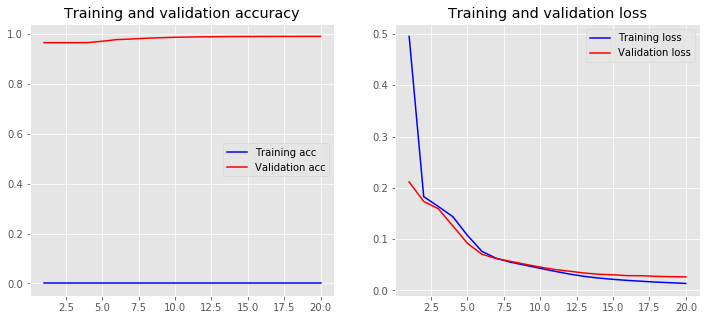

In [13]:
# Plot the graph 
plt.style.use('ggplot')

def plot_history(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, 'b', label='Training acc')
    plt.plot(x, val_accuracy, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)

In [14]:
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i])
        out.append(out_i)
    return out
test_pred = model.predict(X_test, verbose=1)   
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)

7036/7036 [==============================] - 25s 4ms/step


In [15]:
# ! pip install seqeval

     |████████████████████████████████| 51kB 2.7MB/s eta 0:00:011
  Created wheel for seqeval: filename=seqeval-1.2.2-cp36-none-any.whl size=16172 sha256=92489c0594e4760027b2b8a7e5df46f2e00690e01d1862ecf75141999025ac2c
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


In [16]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))


F1-score: 78.8%


In [17]:
# ! pip install sklearn_crfsuite

     |████████████████████████████████| 747kB 4.5MB/s eta 0:00:01


In [18]:
from  sklearn_crfsuite.metrics import flat_classification_report  
report = flat_classification_report(y_pred=pred_labels, y_true=test_labels)
print(report)


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        69
       B-eve       0.00      0.00      0.00        64
       B-geo       0.83      0.86      0.85      7595
       B-gpe       0.94      0.92      0.93      3242
       B-nat       0.00      0.00      0.00        45
       B-org       0.73      0.69      0.71      3927
       B-per       0.83      0.76      0.79      3378
       B-tim       0.90      0.87      0.88      3984
       I-art       0.00      0.00      0.00        38
       I-eve       0.00      0.00      0.00        40
       I-geo       0.77      0.78      0.77      1502
       I-gpe       0.00      0.00      0.00        53
       I-nat       0.00      0.00      0.00        14
       I-org       0.79      0.69      0.74      3150
       I-per       0.87      0.73      0.79      3433
       I-tim       0.85      0.68      0.75      1261
           O       1.00      1.00      1.00    953245

    accuracy              

In [19]:
TP = {}
TN = {}
FP = {}
FN = {}
for tag in tag2idx.keys():
    TP[tag] = 0
    TN[tag] = 0    
    FP[tag] = 0    
    FN[tag] = 0    

def accumulate_score_by_tag(gt, pred):
    """
    For each tag keep stats
    """
    if gt == pred:
        TP[gt] += 1
    elif gt != 'O' and pred == 'O':
        FN[gt] +=1
    elif gt == 'O' and pred != 'O':
        FP[gt] += 1
    else:
        TN[gt] += 1

In [20]:
for i, sentence in enumerate(X_test):
    y_hat = np.argmax(test_pred[0], axis=-1)
    gt = np.argmax(y_test[0], axis=-1)
    for idx, (w,pred) in enumerate(zip(sentence,y_hat)):
        accumulate_score_by_tag(idx2tag[gt[idx]],tags[pred])

In [21]:
for tag in tag2idx.keys():
    print(f'tag:{tag}')    
    print('\t TN:{:10}\tFP:{:10}'.format(TN[tag],FP[tag]))
    print('\t FN:{:10}\tTP:{:10}'.format(FN[tag],TP[tag]))    

tag:unk
	 TN:         0	FP:         0
	 FN:         0	TP:         0
tag:I-gpe
	 TN:         0	FP:         0
	 FN:         0	TP:         0
tag:B-nat
	 TN:         0	FP:         0
	 FN:         0	TP:         0
tag:B-eve
	 TN:         0	FP:         0
	 FN:         0	TP:         0
tag:B-tim
	 TN:         0	FP:         0
	 FN:         0	TP:         0
tag:B-org
	 TN:         0	FP:         0
	 FN:         0	TP:         0
tag:I-eve
	 TN:         0	FP:         0
	 FN:         0	TP:         0
tag:B-art
	 TN:         0	FP:         0
	 FN:         0	TP:         0
tag:I-nat
	 TN:         0	FP:         0
	 FN:         0	TP:         0
tag:B-gpe
	 TN:         0	FP:         0
	 FN:         0	TP:         0
tag:O
	 TN:         0	FP:         0
	 FN:         0	TP:    985040
tag:I-art
	 TN:         0	FP:         0
	 FN:         0	TP:         0
tag:B-geo
	 TN:         0	FP:         0
	 FN:         0	TP:         0
tag:I-tim
	 TN:         0	FP:         0
	 FN:         0	TP:         0
tag:I-per
	 TN:         0	

https://github.com/snehalnair/Named-Entity-Recognition/blob/master/NER.ipynb

In [22]:
data = pd.read_csv('/kaggle/input/entity-annotated-corpus/ner_dataset.csv', encoding= 'unicode_escape')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [23]:
data.shape

(1048575, 4)

In [24]:
from itertools import chain
def get_dict_map(data, token_or_tag):
    tok2idx = {}
    idx2tok = {}
    
    if token_or_tag == 'token':
        vocab = list(set(data['Word'].to_list()))
    else:
        vocab = list(set(data['Tag'].to_list()))
    
    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
    return tok2idx, idx2tok


token2idx, idx2token = get_dict_map(data, 'token')
tag2idx, idx2tag = get_dict_map(data, 'tag')

In [25]:
data['Word_idx'] = data['Word'].map(token2idx)
data['Tag_idx'] = data['Tag'].map(tag2idx)

In [26]:
data.head()

,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,Thousands,NNS,O,11996,9
1,NaN,of,IN,O,26273,9
2,NaN,demonstrators,NNS,O,11926,9
3,NaN,have,VBP,O,34069,9
4,NaN,marched,VBN,O,16639,9


In [27]:
data.isna().any()

Sentence #     True
Word          False
POS           False
Tag           False
Word_idx      False
Tag_idx       False
dtype: bool

In [28]:
data_fillna = data.fillna(method='ffill', axis=0)
data_group = data_fillna.groupby(['Sentence #'],as_index=False
                                )['Word', 'POS', 'Tag', 'Word_idx', 'Tag_idx'].agg(lambda x: list(x))

data_group.head()

,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...","[11996, 26273, 11926, 34069, 16639, 29848, 242...","[9, 9, 9, 9, 9, 9, 11, 9, 9, 9, 9, 9, 11, 9, 9..."
1,Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, J...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[891, 24592, 11626, 18377, 12373, 16318, 19495...","[8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, ..."
2,Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[NN, NNS, NNP, VBD, JJ, NNS, IN, DT, NNP, JJ, ...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O...","[27216, 17666, 27244, 16533, 14864, 35033, 321...","[9, 9, 3, 9, 9, 9, 9, 9, 11, 9, 9, 9, 9, 9, 4,..."
3,Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[PRP, VBD, IN, DT, NN, JJ, NN, IN, NN, NNS, .]","[O, O, O, O, O, O, O, O, O, O, O]","[13171, 2848, 31743, 7531, 7695, 21641, 1703, ...","[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]"
4,Sentence: 10000,"[U.N., relief, coordinator, Jan, Egeland, said...","[NNP, NN, NN, NNP, NNP, VBD, NNP, ,, NNP, ,, J...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo...","[35, 6546, 21146, 17406, 8143, 20273, 1927, 71...","[11, 9, 9, 15, 13, 9, 3, 9, 11, 9, 8, 9, 8, 9,..."


In [29]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [30]:
def get_pad_train_test_val(data_group, data):
    n_token = len(list(set(data['Word'].to_list())))
    n_tag = len(list(set(data['Tag'].to_list())))
    
    tokens = data_group['Word_idx'].tolist()
    maxlen = max([len(s) for s in tokens])
    pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', padding='post', value= n_token - 1)
    
    tags = data_group['Tag_idx'].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', padding='post', value= tag2idx["O"])
    
    n_tags = len(tag2idx)
    pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags]
    
    
    train_tokens, test_tokens, train_tags, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.1, train_size=0.9, random_state=2020)

    print(
        'train_tokens length:', len(train_tokens),
        '\ntest_tokens length:', len(test_tokens),
        '\ntrain_tags:', len(train_tags),
        '\ntest_tags:', len(test_tags)
    )
    
    return train_tokens, test_tokens, train_tags, test_tags

train_tokens, test_tokens, train_tags, test_tags = get_pad_train_test_val(data_group, data)

train_tokens length: 43163 
test_tokens length: 4796 
train_tags: 43163 
test_tags: 4796


In [31]:
for token, tag in zip(train_tokens[0], train_tags[0]):
    print('%s\t%s' % (token, tag))

14652	[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
11626	[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
11613	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
35025	[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
23416	[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
21203	[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
16318	[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
8878	[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
3649	[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
8682	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
713	[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
29898	[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
18377	[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
26352	[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
28704	[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
30776	[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
24092	[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
19

In [32]:
import numpy as np
import tensorflow
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model

# import keras as k

In [33]:
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)

In [34]:
input_dim = len(list(set(data['Word'].to_list())))+1
output_dim = 32
input_length = max([len(s) for s in data_group['Word_idx'].tolist()])
n_tags = len(tag2idx)
print('input_dim: ', input_dim, '\noutput_dim: ', output_dim, '\ninput_length: ', input_length, '\nn_tags: ', n_tags)

input_dim:  35179 
output_dim:  32 
input_length:  104 
n_tags:  17


In [35]:
def get_bilstm_lstm_model():
    model = Sequential()

    # Add Embedding layer
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))

    # Add bidirectional LSTM
    model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat'))

    # Add LSTM
    model.add(LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))

    # Add timeDistributed Layer
    model.add(TimeDistributed(Dense(n_tags, activation="relu")))

    #Optimiser 
    # adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 104, 32)           1125728   
_________________________________________________________________
bidirectional (Bidirectional (None, 104, 64)           16640     
_________________________________________________________________
lstm_1 (LSTM)                (None, 104, 32)           12416     
_________________________________________________________________
time_distributed (TimeDistri (None, 104, 17)           561       
Total params: 1,155,345
Trainable params: 1,155,345
Non-trainable params: 0
_________________________________________________________________


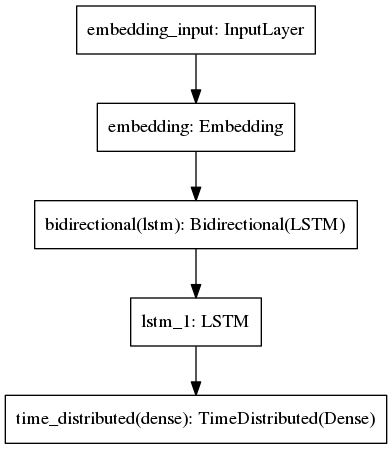

In [36]:
def train_model(X, y, model):
    loss = list()
    for _ in range(25):
        # fit model for one epoch on this sequence
        hist = model.fit(X, y, batch_size=1000, verbose=1, epochs=1, validation_split=0.2)
        loss.append(hist.history['loss'][0])
    return loss
model_bilstm_lstm = get_bilstm_lstm_model()
plot_model(model_bilstm_lstm)

In [37]:
results = pd.DataFrame()
results['with_add_lstm'] = train_model(train_tokens, np.array(train_tags), model_bilstm_lstm)

Train on 34530 samples, validate on 8633 samples
34530/34530 [==============================] - 24s 700us/sample - loss: 1.5286 - accuracy: 0.8462 - val_loss: 0.4325 - val_accuracy: 0.9679
Train on 34530 samples, validate on 8633 samples
34530/34530 [==============================] - 18s 517us/sample - loss: 0.4709 - accuracy: 0.9676 - val_loss: 0.4113 - val_accuracy: 0.9679
Train on 34530 samples, validate on 8633 samples
34530/34530 [==============================] - 18s 518us/sample - loss: 0.4355 - accuracy: 0.9677 - val_loss: 0.4050 - val_accuracy: 0.9679
Train on 34530 samples, validate on 8633 samples
34530/34530 [==============================] - 18s 529us/sample - loss: 0.4195 - accuracy: 0.9677 - val_loss: 0.3917 - val_accuracy: 0.9679
Train on 34530 samples, validate on 8633 samples
34530/34530 [==============================] - 18s 510us/sample - loss: 0.3811 - accuracy: 0.9676 - val_loss: 0.2982 - val_accuracy: 0.9679
Train on 34530 samples, validate on 8633 samples
34530/

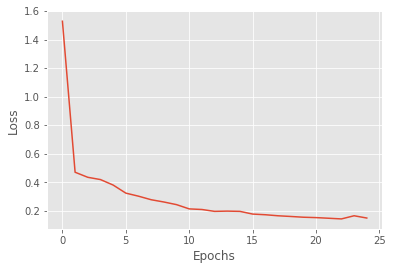

In [38]:
import matplotlib.pyplot as plt
plt.plot(results['with_add_lstm'])
plt.xlabel('Epochs');
plt.ylabel('Loss');

In [39]:
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

In [40]:
text = nlp(
    'Jim bought 300 shares of Acme Corp. in 2006. And producing an annotated block of text that \
    highlights the names of entities: [Jim]Person bought 300 shares of \
    [Acme Corp.]Organization in [2006]Time. In this example, a person name consisting \
    of one token, a two-token company name and a temporal expression have been detected \
    and classified.State-of-the-art NER systems for English produce near-human performance. \
    For example, the best system entering MUC-7 scored 93.39% of F-measure while human \
    annotators scored 97.60% and 96.95%.[1][2]')

In [41]:
for w in text.ents:
    print(w.text, w.label_)

Jim PERSON
300 CARDINAL
Acme Corp. ORG
2006 DATE
300 CARDINAL
Acme Corp.]Organization WORK_OF_ART
2006]Time CARDINAL
one CARDINAL
two CARDINAL
NER ORG
English LANGUAGE
MUC-7 CARDINAL
93.39% PERCENT
97.60% PERCENT


In [42]:
displacy.render(text, style = 'ent', jupyter=True)

In [43]:
spacy.explain('CARDINAL')

'Numerals that do not fall under another type'